In [ ]:
%pip install pymrmr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.5/69.5 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pymrmr: filename=pymrmr-0.1.11-cp312-cp312-linux_x86_64.whl size=411147 sha256=baaed7d0972cc4c2e4731304aa5ff89a1cb6ceb6a409ed8831322835a4baa9e8
  Stored in directory: /root/.cache/pip/wheels/d8/8b/01/15ccb01b7f3703042aef0458e113d6d3568c22d0a54c2974fb
Successfully built pymrmr


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
import pandas as pd
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
import pymrmr
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


In [ ]:
csv_path = '/content/drive/MyDrive/openSMILE_GeMAPSv01b.csv'

df = pd.read_csv(csv_path)

X = df.drop(columns=['label', 'Sex', 'ID','Age'], axis=1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
cv = RepeatedStratifiedKFold(n_repeats=8, n_splits=15, random_state=123)

#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#                     MRMR SVM, XGB, LR                          #
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

n_features = 60
selected_features_mrmr = pymrmr.mRMR(X_train, 'MIQ', n_features)

# Create reduced training and test datasets with selected features
X_train_mrmr = X_train[selected_features_mrmr]
X_test_mrmr = X_test[selected_features_mrmr]


# ============== PIPELINES =======================

gb_mrmr_pipeline = Pipeline(steps=[
    ('model', GradientBoostingClassifier(
        random_state=42,
        learning_rate=0.05,
        max_depth=3,
        n_estimators=50))
])

svm_mrmr_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', SVC(
        random_state=42, probability=True,
        C=10,
        gamma='scale',
        kernel='linear'
    ))
])
xgb_mrmr_pipeline = Pipeline(steps=[
    ('model', XGBClassifier(
        random_state=42,
        learning_rate=0.1,
        max_depth=3,
        n_estimators=100
    ))])

# ================= CVs ================

cv_svm_mrmr = cross_val_score(
        svm_mrmr_pipeline,
        X_train_mrmr,
        y_train,
        cv=cv,
        scoring='roc_auc',
        n_jobs=-1
    )
cv_xgb_mrmr = cross_val_score(
        xgb_mrmr_pipeline,
        X_train_mrmr,
        y_train,
        cv=cv,
        scoring='roc_auc',
        n_jobs=-1,
)

cv_gb_mrmr = cross_val_score(
        gb_mrmr_pipeline,
        X_train_mrmr,
        y_train,
        cv=cv,
        scoring='roc_auc',
        n_jobs=-1,
)



#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#             PCA LR and KNN                                     #
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


# ============== PIPELINES =======================

lr_pca_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=25)),
    ('model', LogisticRegression(
        C=0.1,
        penalty='l2',
        solver='lbfgs',
        random_state=42))
])

knn_pca_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=5)),
    ('model', KNeighborsClassifier(
        n_neighbors=3,
        weights='distance'))
])

# ================= CVs ================

cv_lr_pca = cross_val_score(
        lr_pca_pipeline,
        X_train,
        y_train,
        cv=cv,
        scoring='roc_auc',
        n_jobs=-1,
    )

cv_knn_pca = cross_val_score(
        knn_pca_pipeline,
        X_train,
        y_train,
        cv=cv,
        scoring='roc_auc',
        n_jobs=-1,
    )

# ===================SELECTK RF================================


rf_selectk_pipeline = Pipeline(steps=[
    ('model', RandomForestClassifier(
        random_state=42,
        max_depth=5,
        min_samples_leaf=1,
        min_samples_split=5,
        n_estimators=100
    ))])

cv_rf_selectk = cross_val_score(
        rf_selectk_pipeline,
        X_train,
        y_train,
        cv=cv,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )
# ============================================================
lr_pca_pipeline.fit(X_train, y_train)
svm_mrmr_pipeline.fit(X_train_mrmr, y_train)
knn_pca_pipeline.fit(X_train, y_train)
xgb_mrmr_pipeline.fit(X_train_mrmr, y_train)
rf_selectk_pipeline.fit(X_train, y_train)
gb_mrmr_pipeline.fit(X_train_mrmr, y_train)

svm_mrmr_pred= svm_mrmr_pipeline.predict(X_test_mrmr)
lr_pca_pred= lr_pca_pipeline.predict(X_test)
knn_pca_pred= knn_pca_pipeline.predict(X_test)
xgb_mrmr_pred = xgb_mrmr_pipeline.predict(X_test_mrmr)
gb_mrmr_pred = gb_mrmr_pipeline.predict(X_test_mrmr)
rf_selectk_pred = rf_selectk_pipeline.predict(X_test)

# Calculate test accuracy
lr_pca_accuracy = accuracy_score(y_test, lr_pca_pred)
knn_pca_accuracy = accuracy_score(y_test, knn_pca_pred)
svm_mrmr_accuracy = accuracy_score(y_test, svm_mrmr_pred)
xgb_accuracy = accuracy_score(y_test, xgb_mrmr_pred)
gb_mrmr_accuracy = accuracy_score(y_test, gb_mrmr_pred)
rf_selectk_accuracy = accuracy_score(y_test, rf_selectk_pred)

print(f"KNN PCA accuracy: {knn_pca_accuracy}")
print(f"LR PCA accuracy: {lr_pca_accuracy}")
print(f"SVM mRMR accuracy: {svm_mrmr_accuracy}")
print(f"XGB mRMR accuracy: {xgb_accuracy}")
print(f"RF SelectK accuracy: {rf_selectk_accuracy}")
print(f"GB MRMR accuracy: {gb_mrmr_accuracy}")

print(f"XGB mRMR - Mean CV AUC: {np.mean(cv_xgb_mrmr):.4f} (±{np.std(cv_xgb_mrmr):.4f})")
print(f"SVM mMRMR - Mean CV AUC: {np.mean(cv_svm_mrmr):.4f} (±{np.std(cv_svm_mrmr):.4f})")
print(f"LR PCA - Mean CV AUC: {np.mean(cv_lr_pca):.4f} (±{np.std(cv_lr_pca):.4f})")
print(f"KNN PCA - Mean CV AUC: {np.mean(cv_knn_pca):.4f} (±{np.std(cv_knn_pca):.4f})")
print(f"RF SelectK - Mean CV AUC: {np.mean(cv_rf_selectk):.4f} (±{np.std(cv_rf_selectk):.4f})")
print(f"GB MRMR - Mean CV AUC: {np.mean(cv_gb_mrmr):.4f} (±{np.std(cv_gb_mrmr):.4f})")



#WHY ARE VALUES CHANGING

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   31.8s finished


KNN PCA accuracy: 0.7058823529411765
LR PCA accuracy: 0.8823529411764706
SVM mRMR accuracy: 0.7058823529411765
XGB mRMR accuracy: 0.8235294117647058
RF SelectK accuracy: 0.7647058823529411
GB MRMR accuracy: 0.5882352941176471
XGB mRMR - Mean CV AUC: 0.6674 (±0.2769)
SVM mMRMR - Mean CV AUC: 0.7486 (±0.2591)
LR PCA - Mean CV AUC: 0.7111 (±0.2741)
KNN PCA - Mean CV AUC: 0.7330 (±0.2679)
RF SelectK - Mean CV AUC: 0.6604 (±0.2711)
GB MRMR - Mean CV AUC: 0.7556 (±0.2657)


In [ ]:
# Create a dictionary of the trained models
models = {
    'LR PCA': lr_pca_pipeline,
    'KNN PCA': knn_pca_pipeline,
    'SVM mRMR': svm_mrmr_pipeline,
    'XGB mRMR': xgb_mrmr_pipeline,
    'RF SelectK': rf_selectk_pipeline,
    'GB MRMR': gb_mrmr_pipeline
}

# Define the cross-validation strategy
cv = RepeatedStratifiedKFold(n_repeats=8, n_splits=13, random_state=123)

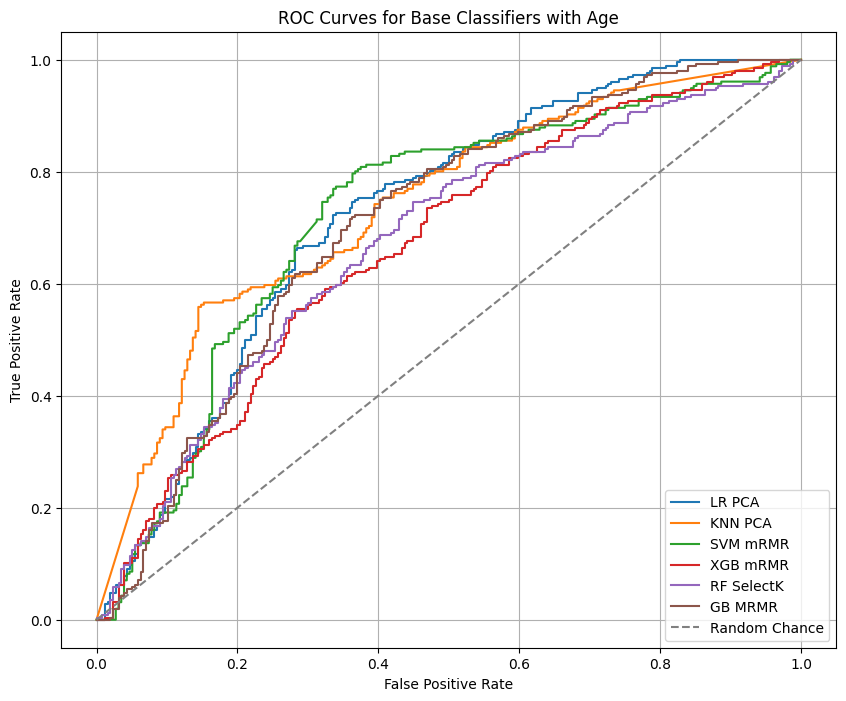

In [ ]:
plt.figure(figsize=(10, 8))
ax = plt.gca()

from sklearn.metrics import roc_curve, auc

auc_scores = {
    # 'XGB mRMR': {'mean': np.mean(cv_xgb_mrmr), 'std': np.std(cv_xgb_mrmr)},
    # 'SVM mMRMR': {'mean': np.mean(cv_svm_mrmr), 'std': np.std(cv_svm_mrmr)},
    # 'LR PCA': {'mean': np.mean(cv_lr_pca), 'std': np.std(cv_lr_pca)},
    # 'KNN PCA': {'mean': np.mean(cv_knn_pca), 'std': np.std(cv_knn_pca)},
    # 'RF SelectK': {'mean': np.mean(cv_rf_selectk), 'std': np.std(cv_rf_selectk)},
    # 'GB MRMR': {'mean': np.mean(cv_gb_mrmr), 'std': np.std(cv_gb_mrmr)}
}

roc_data = {}  # Re-initialize roc_data
ensemble_data = {'y_true': [], 'y_probs': []}  # For ensemble predictions

for fold, (train_index, val_index) in enumerate(cv.split(X_train, y_train)):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    #store predictions for this fold
    fold_predictions = []

    for model_name, model in models.items():
        model.fit(X_train_fold, y_train_fold)
        y_probs = model.predict_proba(X_val_fold)[:, 1]

        if model_name not in roc_data:
            roc_data[model_name] = {'y_true': [], 'y_probs': []}
        roc_data[model_name]['y_true'].extend(y_val_fold.tolist())
        roc_data[model_name]['y_probs'].extend(y_probs.tolist())

        fold_predictions.append(y_probs)

#calc ROC curve for each model using the accumulated data
for model_name, data in roc_data.items():
    fpr, tpr, _ = roc_curve(data['y_true'], data['y_probs'])
    label = f'{model_name}'

    ax.plot(fpr, tpr, label=label)


#plor random guessing line
ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Chance')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Base Classifiers with Age')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

wanna check the classification matrices per y_true

In [ ]:
sample_df = pd.DataFrame({'y_true': y_test.reset_index(drop=True)})
sample_df['lr_pca'] = lr_pca_pred
sample_df['knn_pca'] = knn_pca_pred
sample_df['svm_mrmr'] = svm_mrmr_pred
sample_df['xgb_mrmr'] = xgb_mrmr_pred
sample_df['rf_selectk'] = rf_selectk_pred
sample_df['gb_mrmr'] = gb_mrmr_pred
print(sample_df)


    y_true  lr_pca  knn_pca  svm_mrmr  xgb_mrmr  rf_selectk  gb_mrmr
0        0       0        0         0         0           0        1
1        0       0        0         0         0           0        0
2        1       1        0         1         0           0        1
3        1       1        1         1         1           0        0
4        1       1        1         1         1           1        1
5        0       0        0         0         0           0        0
6        0       0        0         0         0           0        0
7        1       1        0         1         1           1        1
8        0       0        1         1         0           0        1
9        1       0        0         0         0           0        0
10       0       1        0         1         0           0        0
11       0       0        1         0         0           0        1
12       0       0        0         0         0           0        1
13       0       0        0       

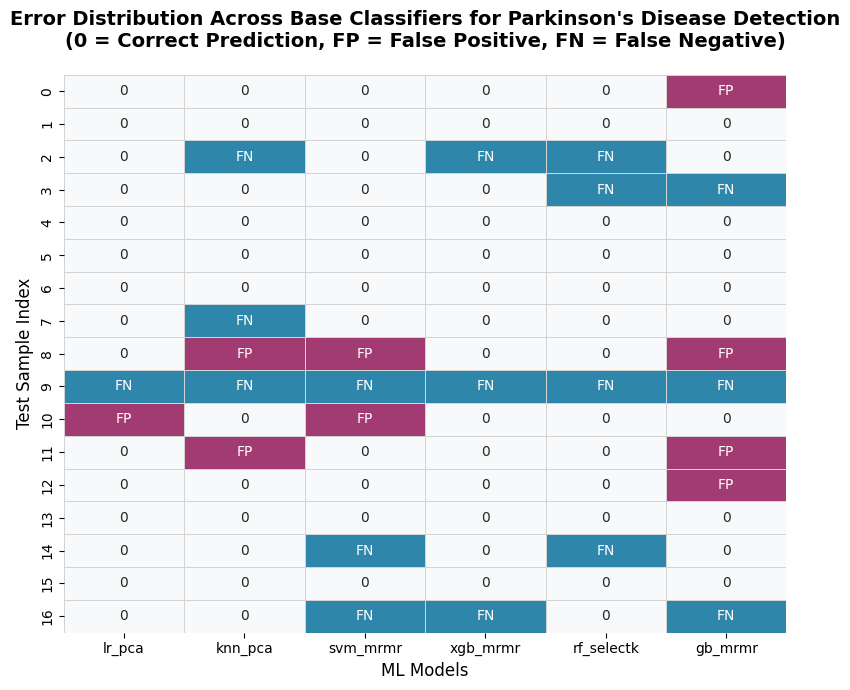

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

color_df = pd.DataFrame(index=sample_df.index, columns=sample_df.columns)
# 'y_true' column not needed for the heatmap values
color_df = color_df.drop(columns=['y_true'])


for model_name in color_df.columns:
    for idx in sample_df.index:
        true = sample_df.loc[idx, 'y_true']
        pred = sample_df.loc[idx, model_name]
        if pred == true:
            color_df.loc[idx, model_name] = 0  #correct
        elif pred == 1 and true == 0:
            color_df.loc[idx, model_name] = 1  #false positive
        elif pred == 0 and true == 1:
            color_df.loc[idx, model_name] = -1  #false negative

plt.figure(figsize=(8, 7))

#create annotation with symbols for readability
annotation_df = color_df.copy()
annotation_df = annotation_df.replace({0: '0', 1: 'FP', -1: 'FN'})

cmap = sns.color_palette(["#2E86AB", "#F8F9FA", "#A23B72"])

ax = sns.heatmap(color_df.astype(float),
                 annot=annotation_df,
                 fmt='',
                 cmap=cmap,
                 cbar=False,
                 linewidths=0.5,
                 linecolor='lightgray')

#labesl
plt.xlabel('ML Models', fontsize=12)
plt.ylabel('Test Sample Index', fontsize=12)
plt.title('Error Distribution Across Base Classifiers for Parkinson\'s Disease Detection\n'
          '(0 = Correct Prediction, FP = False Positive, FN = False Negative)',
          fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('model_error_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.model_selection import cross_val_score

#list of base estimators
estimators = [
    ('lr_pca', lr_pca_pipeline),
    ('knn_pca', knn_pca_pipeline),
    ('svm_mrmr', svm_mrmr_pipeline),
    ('xgb_mrmr', xgb_mrmr_pipeline),
    ('rf_selectk', rf_selectk_pipeline),
    ('gb_mrmr', gb_mrmr_pipeline)
]

#Hard Voting Classifier
hard_voting_clf = VotingClassifier(estimators=estimators, voting='hard')
hard_voting_clf.fit(X_train, y_train)
hard_voting_pred = hard_voting_clf.predict(X_test)
hard_voting_accuracy = accuracy_score(y_test, hard_voting_pred)
print(f"Hard Voting Classifier Accuracy: {hard_voting_accuracy:.4f}")

#Soft Voting Classifier (all models must have predict_proba)
soft_voting_clf = VotingClassifier(estimators=estimators, voting='soft', weights=[0.3, 0.1, 0.2, 0.1, 0.1, 0.2])
soft_voting_clf.fit(X_train, y_train)
soft_voting_pred = soft_voting_clf.predict(X_test)
soft_voting_accuracy = accuracy_score(y_test, soft_voting_pred)
print(f"Soft Voting Classifier Accuracy: {soft_voting_accuracy:.4f}")


#Stacking Classifier
#using Logistic Regression as the final estimator
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stacking_clf.fit(X_train, y_train)
stacking_pred = stacking_clf.predict(X_test)
stacking_accuracy = accuracy_score(y_test, stacking_pred)
print(f"Stacking Classifier Accuracy: {stacking_accuracy:.4f}")


#to find CV AUC we need to run cross_val_score, once for mean cv, and one for mean cv auc
# Perform cross-validation for ensemble models
cv_hard_voting_acc = cross_val_score(hard_voting_clf, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)
cv_hard_voting_auc = cross_val_score(hard_voting_clf, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)

cv_soft_voting_acc = cross_val_score(soft_voting_clf, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)
cv_soft_voting_auc = cross_val_score(soft_voting_clf, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)

cv_stacking_acc = cross_val_score(stacking_clf, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)
cv_stacking_auc = cross_val_score(stacking_clf, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=11)

print(f"\nHard Voting - Mean CV Accuracy: {np.mean(cv_hard_voting_acc):.4f} (±{np.std(cv_hard_voting_acc):.4f})")
print(f"Hard Voting - Mean CV AUC: {np.mean(cv_hard_voting_auc):.4f} (±{np.std(cv_hard_voting_auc):.4f})")

print(f"Soft Voting - Mean CV Accuracy: {np.mean(cv_soft_voting_acc):.4f} (±{np.std(cv_soft_voting_acc):.4f})")
print(f"Soft Voting - Mean CV AUC: {np.mean(cv_soft_voting_auc):.4f} (±{np.std(cv_soft_voting_auc):.4f})")

print(f"Stacking - Mean CV Accuracy: {np.mean(cv_stacking_acc):.4f} (±{np.std(cv_stacking_acc):.4f})")
print(f"Stacking - Mean CV AUC: {np.mean(cv_stacking_auc):.4f} (±{np.std(cv_stacking_auc):.4f})")

Hard Voting Classifier Accuracy: 0.7647
Soft Voting Classifier Accuracy: 0.8235
Stacking Classifier Accuracy: 0.7647


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   45.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   41.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   44.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   47.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Don


Hard Voting - Mean CV Accuracy: 0.6862 (±0.2220)
Hard Voting - Mean CV AUC: nan (±nan)
Soft Voting - Mean CV Accuracy: 0.7496 (±0.1971)
Soft Voting - Mean CV AUC: 0.7840 (±0.2469)
Stacking - Mean CV Accuracy: 0.7179 (±0.1912)
Stacking - Mean CV AUC: 0.7681 (±0.2551)


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  4.1min finished


In [ ]:
sample_df = pd.DataFrame({'y_true': y_test.reset_index(drop=True)})
sample_df['lr_pca'] = lr_pca_pred
sample_df['knn_pca'] = knn_pca_pred
sample_df['svm_mrmr'] = svm_mrmr_pred
sample_df['xgb_mrmr'] = xgb_mrmr_pred
sample_df['rf_selectk'] = rf_selectk_pred
sample_df['gb_mrmr'] = gb_mrmr_pred
print(sample_df)

    y_true  lr_pca  knn_pca  svm_mrmr  xgb_mrmr  rf_selectk  gb_mrmr
0        0       1        0         0         1           1        1
1        0       0        0         0         0           0        0
2        1       1        1         1         1           1        1
3        1       0        1         0         0           0        0
4        1       1        1         1         1           1        1
5        0       0        0         0         0           0        1
6        0       0        0         0         0           0        0
7        1       0        0         0         0           1        0
8        0       0        1         0         0           0        0
9        1       0        0         0         0           0        0
10       0       0        0         1         0           0        0
11       0       0        1         0         0           0        0
12       0       0        0         0         0           0        0
13       0       0        0       

print accuracy, precision recall and all for the models

In [1]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

#calculate and print precision, recall, and F1-score for each model
print("\nTest Set Metrics (macro avg):")
print("-" * 40)

def print_metrics(model_name, y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"{model_name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

print_metrics("LR PCA", y_test, lr_pca_pred)
print_metrics("KNN PCA", y_test, knn_pca_pred)
print_metrics("SVM mRMR", y_test, svm_mrmr_pred)
print_metrics("XGB mRMR", y_test, xgb_mrmr_pred)
print_metrics("RF SelectK", y_test, rf_selectk_pred)
print_metrics("GB MRMR", y_test, gb_mrmr_pred)
print_metrics("Hard Voting", y_test, hard_voting_pred)
print_metrics("Soft Voting", y_test, soft_voting_pred)
print_metrics("Stacking", y_test, stacking_pred)

KeyboardInterrupt: 